### STEP 7 : 다른 주식 종목 예측해 보기_NAVER

In [1]:
import pandas as pd
import sklearn
import statsmodels
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

# print(pandas.__version__)
# print(sklearn.__version__)
# print(statsmodels.__version__)

__데이터셋 준비__

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

path = "~/aiffel/stock_prediction/data/"
df = pd.read_csv(f"{path}AAPL.csv", index_col = "Date", parse_dates = True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-09-20,143.800003,144.839996,141.270004,142.940002,142.143494,123478900
2021-09-21,143.929993,144.600006,142.779999,143.429993,142.630753,75834000
2021-09-22,144.449997,146.429993,143.699997,145.850006,145.037277,76404300
2021-09-23,146.649994,147.080002,145.639999,146.830002,146.011826,64838200
2021-09-24,145.660004,147.470001,145.559998,146.919998,146.101303,53477900


In [3]:
ts = df["Close"]
ts

Date
2021-09-20    142.940002
2021-09-21    143.429993
2021-09-22    145.850006
2021-09-23    146.830002
2021-09-24    146.919998
                 ...    
2022-09-13    153.839996
2022-09-14    155.309998
2022-09-15    152.369995
2022-09-16    150.699997
2022-09-19    154.479996
Name: Close, Length: 252, dtype: float64

### STEP 2 :  각종 전처리 수행

In [4]:
# 결측치 처리
ts = ts.interpolate(method = "time")
ts[ts.isna()]
# 결측치가 없음

Series([], Name: Close, dtype: float64)

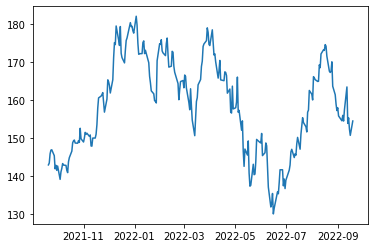

In [5]:
# 원본 데이터 
plt.plot(ts)

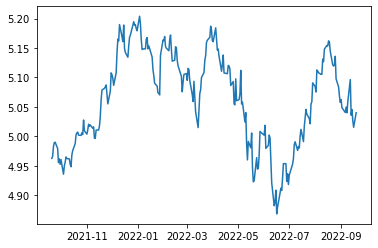

In [6]:
# 로그 변환
ts_log = np.log(ts)

# 로그 변환 그래프
plt.plot(ts_log)

### STEP 3 : 시계열 안정성 분석

In [7]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [8]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

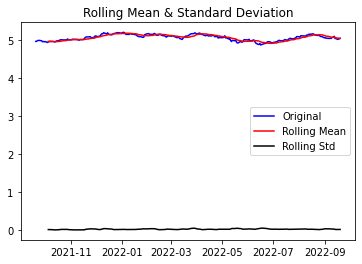

Results of Dickey-Fuller Test:
Test Statistic                  -2.171407
p-value                          0.216786
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


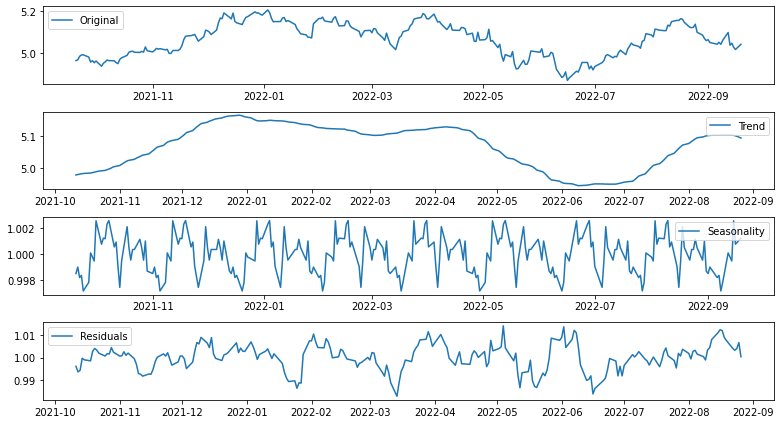

In [9]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화)
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [10]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.922544
p-value                          0.000032
#Lags Used                      11.000000
Number of Observations Used    210.000000
Critical Value (1%)             -3.461879
Critical Value (5%)             -2.875404
Critical Value (10%)            -2.574159
dtype: float64


- p-value가 충분히 작아서 안정성이 높다고 볼 수 있다. 

### STEP 4 : 학습, 테스트 데이터셋 생성

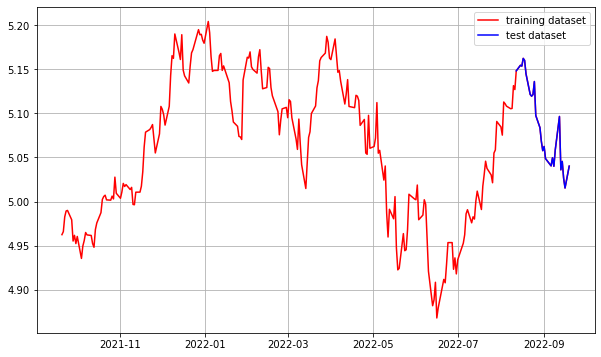

In [11]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()
plt.show()

### STEP 5 : 적정 ARIMA 모수 찾기

__원본 데이터__

Results of Dickey-Fuller Test:
Test Statistic                  -2.171407
p-value                          0.216786
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


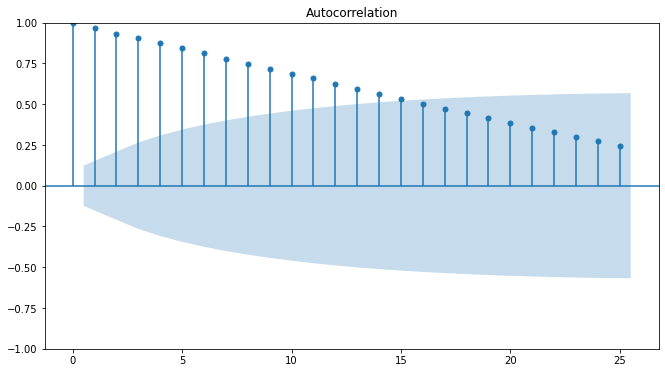

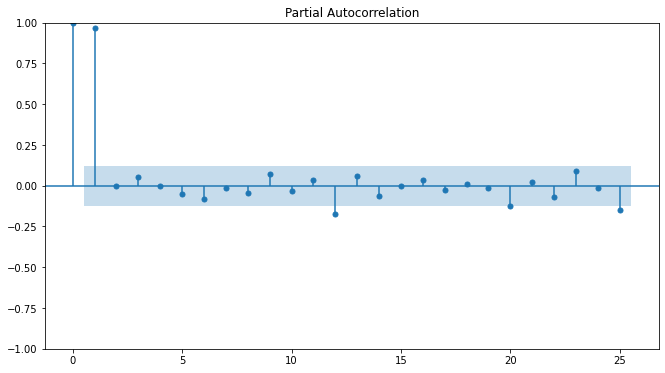

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

augmented_dickey_fuller_test(ts_log)

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

__1차 차분__

Results of Dickey-Fuller Test:
Test Statistic                -1.601270e+01
p-value                        6.329971e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


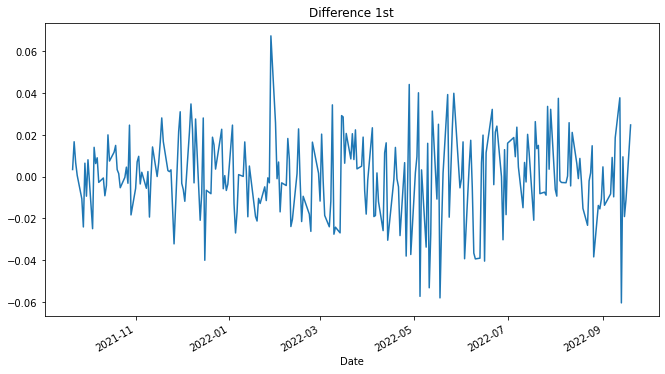

In [13]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]  #diff 차분 인자
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


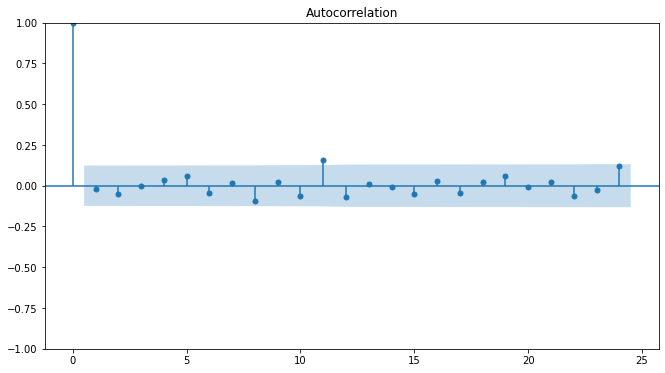

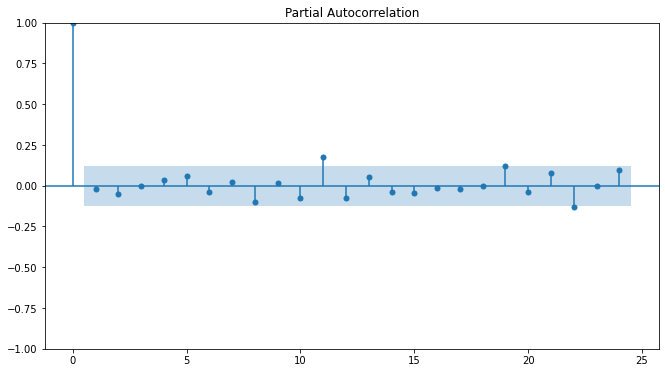

In [14]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(diff_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

__2차 차분__

Results of Dickey-Fuller Test:
Test Statistic                -7.914125e+00
p-value                        3.877038e-12
#Lags Used                     1.100000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


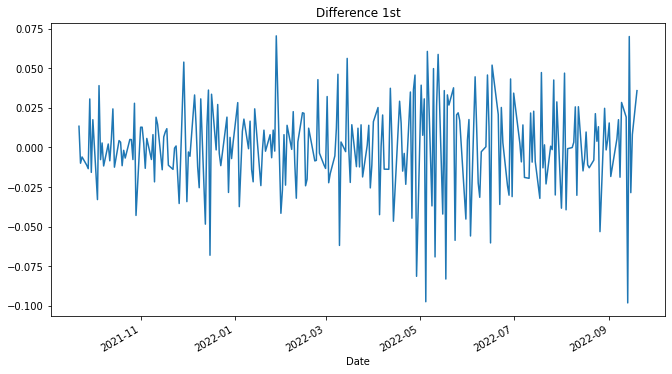

In [15]:
# 2 차 차분
diff_2 = diff_1.diff(periods=1).iloc[1:]  #diff 차분 인자
diff_2.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_2)

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


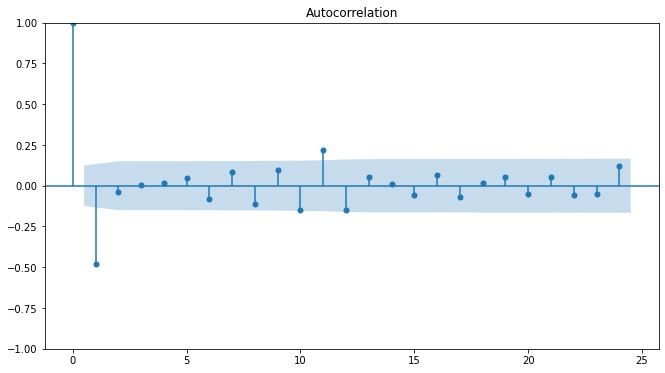

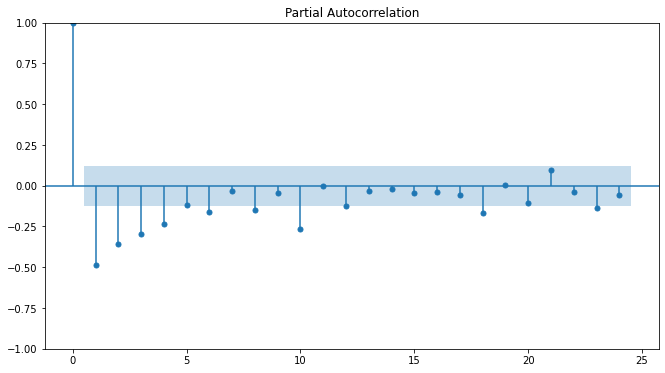

In [16]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(diff_2)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_2)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### STEP 6 : ARIMA 모델 훈련과 테스트

In [26]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 0, 1)) # 모수는 이전 그래프를 참고 , (p,d,q)
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 566.444
Date:                Tue, 20 Sep 2022   AIC                          -1124.888
Time:                        11:17:33   BIC                          -1111.206
Sample:                             0   HQIC                         -1119.367
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0558      0.038    134.325      0.000       4.982       5.130
ar.L1          0.9694      0.019     51.510      0.000       0.932       1.006
ma.L1          0.0164      0.066      0.247      0.8

__예측__

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


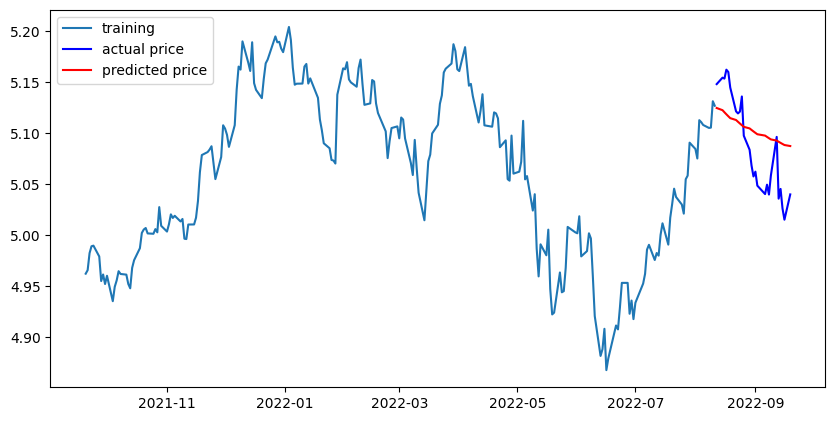

In [27]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  42.41635033485416
MAE:  5.866513332810578
RMSE:  6.512783608784662
MAPE: 3.67%


### 회고

- p, d, q 를 그래프를 보고 추론해서 경향성을 맞추는데 까지는 성공했다.
- 시계열의 안정성을 체크할 떼, p-value가 너무 0에 가까운 것도 문제가 된다는 것을 알게 되었다. 
- 사실 아직 왜 예측률이 좋아지는지 모르겠다.